# メーカーごとのデータ数が極端に少ない値を外れ値にして予測  
# encodingをダミーエンコーディングで実装

In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score,mean_absolute_percentage_error

import lightgbm as lgb
import optuna.integration.lightgbm as opt_lgb
import optuna
import matplotlib.pyplot as plt
import japanize_matplotlib

looker studioでパレート図(横軸メーカー、縦軸データ数)を作った結果  
下位10メーカーはデータが2個以下しかないため、使用できないと判断し、外れ値とした。

In [2]:
#データの読み込み
train_data = pd.read_csv("../data/機械学習用/train_data.csv",index_col=0)
model_data = pd.read_csv('../data/アップロード用/model_data.csv',index_col=0)
info_data = pd.read_csv('../data/アップロード用/bike_info.csv',index_col=0)
#サンプルサイズが少ないモデルを抽出
all_data = info_data.merge(model_data,on='model_number',how='left')
brand_count = all_data.groupby('brand').size().sort_values(ascending=True)
#下位10メーカーを抽出(上のcountデータがすでに照準のため上から９つを抽出する)
low_10 = brand_count.index[0:10]
model_data = model_data[~model_data['brand'].isin(low_10)]
#このメーカーデータを使ってtrainデータに結合
train_data = train_data.merge(model_data,on='model_number',how='left')
#先ほど外れ値に指定したデータはnullになるため、dropnaをすればok
train_data.dropna(inplace=True)

# モデルの作成  
使用する特徴量  
* model_year
* color
* mileage 
* gurantee_period
* brand
* type
* displacement  

In [3]:
#ダミーエンコーディング  
#色、ブランド、typeは名義尺度のため、本来ラベルエンコーディングは不適当なため、dummy変数化
#oe =OrdinalEncoder()
#エンコーディングしたい列
encoding_target = ['color','brand','type']
#train_data[encoding_target] = oe.fit_transform(train_data[encoding_target].values)

In [4]:
train_data=pd.get_dummies(train_data,drop_first=True,columns=encoding_target)

In [5]:
#説明変数と目的変数の抽出
X = train_data.iloc[:,2:].drop(columns=['model_number','name','store_id']).values
y = train_data['cost'].values

In [6]:
#学習データと検証データへの分割
X_learn,X_val,y_learn,y_val = train_test_split(X,y,test_size=0.2,random_state=123)

In [7]:
lr_ds = opt_lgb.Dataset(X_learn,y_learn)
val_ds = opt_lgb.Dataset(X_val,y_val)

#固定するparamsは先に指定
params ={
    'objective':'regression',
    'metric':'mape'
}

#クロスバリデーションによるパラメータの探索 5Fold
tuner = opt_lgb.LightGBMTunerCV(params,
                                lr_ds,
                                num_boost_round=10000,
                                verbose_eval=100,
                                early_stopping_rounds=100,
                                folds =KFold(n_splits=5))

tuner.run()

[I 2023-11-29 14:14:34,399] A new study created in memory with name: no-name-65aa5321-e0c1-441f-8d09-c6f4f882d5b6
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_col_wise=true` t

feature_fraction, val_score: 0.184659:  14%|#4        | 1/7 [00:02<00:16,  2.74s/it]

Early stopping, best iteration is:
[126]	cv_agg's valid mape: 0.184659 + 0.00687306
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

feature_fraction, val_score: 0.176038:  29%|##8       | 2/7 [00:05<00:12,  2.53s/it]

Early stopping, best iteration is:
[91]	cv_agg's valid mape: 0.176038 + 0.00753832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

feature_fraction, val_score: 0.176038:  43%|####2     | 3/7 [00:08<00:10,  2.71s/it]

Early stopping, best iteration is:
[137]	cv_agg's valid mape: 0.179471 + 0.00810669
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

feature_fraction, val_score: 0.176038:  57%|#####7    | 4/7 [00:11<00:09,  3.09s/it]

[300]	cv_agg's valid mape: 0.207593 + 0.00852387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[217]	cv_agg's valid mape: 0.206627 + 0.00914983
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM]

feature_fraction, val_score: 0.176038:  71%|#######1  | 5/7 [00:14<00:05,  2.82s/it]

[200]	cv_agg's valid mape: 0.181188 + 0.0100956
Early stopping, best iteration is:
[103]	cv_agg's valid mape: 0.178037 + 0.00935642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightG

feature_fraction, val_score: 0.172776:  86%|########5 | 6/7 [00:16<00:02,  2.68s/it]

Early stopping, best iteration is:
[92]	cv_agg's valid mape: 0.172776 + 0.00689392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used featu

feature_fraction, val_score: 0.172776: 100%|##########| 7/7 [00:19<00:00,  2.78s/it]


Early stopping, best iteration is:
[140]	cv_agg's valid mape: 0.190937 + 0.00959887


num_leaves, val_score: 0.172776:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` t

num_leaves, val_score: 0.164621:   5%|5         | 1/20 [00:34<10:56, 34.56s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[53]	cv_agg's valid mape: 0.164621 + 0.00741151
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of

num_leaves, val_score: 0.164480:  10%|#         | 2/20 [00:39<05:05, 16.95s/it]

Early stopping, best iteration is:
[51]	cv_agg's valid mape: 0.16448 + 0.00739401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading,

num_leaves, val_score: 0.164480:  15%|#5        | 3/20 [00:44<03:20, 11.79s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.164480:  20%|##        | 4/20 [00:46<02:07,  7.96s/it]

Early stopping, best iteration is:
[387]	cv_agg's valid mape: 0.184237 + 0.00510043
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

num_leaves, val_score: 0.163397:  25%|##5       | 5/20 [00:51<01:41,  6.78s/it]

Early stopping, best iteration is:
[55]	cv_agg's valid mape: 0.163397 + 0.00677434
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

num_leaves, val_score: 0.163397:  30%|###       | 6/20 [00:55<01:20,  5.72s/it]

Early stopping, best iteration is:
[59]	cv_agg's valid mape: 0.164462 + 0.00744822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading

num_leaves, val_score: 0.163397:  35%|###5      | 7/20 [00:58<01:04,  4.93s/it]

Early stopping, best iteration is:
[65]	cv_agg's valid mape: 0.167991 + 0.00641674
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

num_leaves, val_score: 0.163397:  40%|####      | 8/20 [01:04<01:01,  5.09s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.163397:  45%|####5     | 9/20 [01:07<00:49,  4.52s/it]

Early stopping, best iteration is:
[59]	cv_agg's valid mape: 0.164462 + 0.00744822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading

num_leaves, val_score: 0.163397:  50%|#####     | 10/20 [01:12<00:47,  4.71s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.163397:  55%|#####5    | 11/20 [01:14<00:34,  3.88s/it]

Early stopping, best iteration is:
[271]	cv_agg's valid mape: 0.179727 + 0.00833033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

num_leaves, val_score: 0.163397:  60%|######    | 12/20 [04:16<07:45, 58.20s/it]

Early stopping, best iteration is:
[52]	cv_agg's valid mape: 0.164218 + 0.00814861
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

num_leaves, val_score: 0.163397:  65%|######5   | 13/20 [04:22<04:56, 42.32s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[53]	cv_agg's valid mape: 0.164621 + 0.00741151
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] 

num_leaves, val_score: 0.163397:  70%|#######   | 14/20 [04:28<03:07, 31.19s/it]

Early stopping, best iteration is:
[53]	cv_agg's valid mape: 0.164468 + 0.00768318
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

num_leaves, val_score: 0.163397:  75%|#######5  | 15/20 [04:31<01:54, 22.86s/it]

Early stopping, best iteration is:
[61]	cv_agg's valid mape: 0.165396 + 0.00565286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used featu

num_leaves, val_score: 0.163397:  80%|########  | 16/20 [04:36<01:09, 17.48s/it]

Early stopping, best iteration is:
[51]	cv_agg's valid mape: 0.16476 + 0.00747644
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading,

num_leaves, val_score: 0.163397:  85%|########5 | 17/20 [04:39<00:39, 13.06s/it]

Early stopping, best iteration is:
[71]	cv_agg's valid mape: 0.168609 + 0.00424892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

num_leaves, val_score: 0.163397:  90%|######### | 18/20 [04:45<00:21, 10.83s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.163394:  95%|#########5| 19/20 [04:49<00:08,  8.96s/it]

Early stopping, best iteration is:
[51]	cv_agg's valid mape: 0.163394 + 0.00732281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

num_leaves, val_score: 0.163394: 100%|##########| 20/20 [04:55<00:00, 14.77s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

bagging, val_score: 0.163394:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` t

bagging, val_score: 0.163394:  10%|#         | 1/10 [00:04<00:36,  4.02s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iter

bagging, val_score: 0.163394:  20%|##        | 2/10 [00:09<00:39,  4.97s/it]

Early stopping, best iteration is:
[55]	cv_agg's valid mape: 0.164677 + 0.00625812
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

bagging, val_score: 0.163394:  30%|###       | 3/10 [00:13<00:30,  4.38s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[95]	cv_agg's valid mape: 0.180183 + 0.0076664
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing

bagging, val_score: 0.163394:  40%|####      | 4/10 [00:18<00:28,  4.78s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[65]	cv_agg's valid mape: 0.16572 + 0.00751206
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise mul

bagging, val_score: 0.163394:  50%|#####     | 5/10 [00:22<00:22,  4.58s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

bagging, val_score: 0.163394:  60%|######    | 6/10 [00:27<00:17,  4.47s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

bagging, val_score: 0.163394:  70%|#######   | 7/10 [00:30<00:12,  4.09s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

bagging, val_score: 0.163394:  80%|########  | 8/10 [00:36<00:09,  4.66s/it]

Early stopping, best iteration is:
[63]	cv_agg's valid mape: 0.164163 + 0.00767588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

bagging, val_score: 0.163394:  90%|######### | 9/10 [00:41<00:04,  4.89s/it]

Early stopping, best iteration is:
[52]	cv_agg's valid mape: 0.165123 + 0.00693197
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading

bagging, val_score: 0.163394: 100%|##########| 10/10 [00:47<00:00,  4.71s/it]


Early stopping, best iteration is:
[49]	cv_agg's valid mape: 0.166292 + 0.00595193


feature_fraction_stage2, val_score: 0.163394:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

feature_fraction_stage2, val_score: 0.163394:  33%|###3      | 1/3 [00:05<00:10,  5.14s/it]

Early stopping, best iteration is:
[58]	cv_agg's valid mape: 0.164104 + 0.00560112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

feature_fraction_stage2, val_score: 0.163394:  67%|######6   | 2/3 [00:09<00:04,  4.96s/it]

Early stopping, best iteration is:
[53]	cv_agg's valid mape: 0.165133 + 0.00541548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used featu

feature_fraction_stage2, val_score: 0.163394: 100%|##########| 3/3 [00:14<00:00,  4.98s/it]


Early stopping, best iteration is:
[51]	cv_agg's valid mape: 0.163394 + 0.00732281


regularization_factors, val_score: 0.163394:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_col_wise=true` t

regularization_factors, val_score: 0.163061:   5%|5         | 1/20 [00:04<01:32,  4.86s/it]

Early stopping, best iteration is:
[54]	cv_agg's valid mape: 0.163061 + 0.00636661
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163061:  10%|#         | 2/20 [00:09<01:26,  4.80s/it]

Early stopping, best iteration is:
[52]	cv_agg's valid mape: 0.163412 + 0.00713529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163061:  15%|#5        | 3/20 [00:14<01:22,  4.85s/it]

Early stopping, best iteration is:
[56]	cv_agg's valid mape: 0.163516 + 0.00702823
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163061:  20%|##        | 4/20 [00:19<01:17,  4.84s/it]

Early stopping, best iteration is:
[55]	cv_agg's valid mape: 0.163092 + 0.00654508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163061:  25%|##5       | 5/20 [00:24<01:12,  4.85s/it]

Early stopping, best iteration is:
[54]	cv_agg's valid mape: 0.163857 + 0.00770374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163061:  30%|###       | 6/20 [00:29<01:08,  4.86s/it]

Early stopping, best iteration is:
[56]	cv_agg's valid mape: 0.163384 + 0.00612035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163061:  35%|###5      | 7/20 [00:34<01:03,  4.90s/it]

Early stopping, best iteration is:
[59]	cv_agg's valid mape: 0.163295 + 0.00664726
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163061:  40%|####      | 8/20 [00:38<00:58,  4.88s/it]

Early stopping, best iteration is:
[54]	cv_agg's valid mape: 0.163241 + 0.00610585
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163061:  45%|####5     | 9/20 [00:44<00:54,  4.99s/it]

Early stopping, best iteration is:
[66]	cv_agg's valid mape: 0.163783 + 0.00745709
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163061:  50%|#####     | 10/20 [00:49<00:50,  5.04s/it]

Early stopping, best iteration is:
[56]	cv_agg's valid mape: 0.163174 + 0.00643046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163061:  55%|#####5    | 11/20 [00:54<00:45,  5.05s/it]

Early stopping, best iteration is:
[61]	cv_agg's valid mape: 0.163445 + 0.00693027
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163061:  60%|######    | 12/20 [00:59<00:40,  5.01s/it]

Early stopping, best iteration is:
[56]	cv_agg's valid mape: 0.16348 + 0.00657033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading,

regularization_factors, val_score: 0.163061:  65%|######5   | 13/20 [01:04<00:35,  5.00s/it]

Early stopping, best iteration is:
[59]	cv_agg's valid mape: 0.163297 + 0.0066483
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading,

regularization_factors, val_score: 0.163061:  70%|#######   | 14/20 [01:08<00:29,  4.92s/it]

Early stopping, best iteration is:
[52]	cv_agg's valid mape: 0.163826 + 0.00566022
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163061:  75%|#######5  | 15/20 [01:14<00:24,  4.97s/it]

Early stopping, best iteration is:
[54]	cv_agg's valid mape: 0.163474 + 0.00706477
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading

regularization_factors, val_score: 0.163061:  80%|########  | 16/20 [01:19<00:19,  4.97s/it]

Early stopping, best iteration is:
[51]	cv_agg's valid mape: 0.164028 + 0.00710897
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.162845:  85%|########5 | 17/20 [01:23<00:14,  4.91s/it]

Early stopping, best iteration is:
[52]	cv_agg's valid mape: 0.162845 + 0.00657102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.162845:  90%|######### | 18/20 [01:28<00:09,  4.88s/it]

Early stopping, best iteration is:
[51]	cv_agg's valid mape: 0.163338 + 0.00715167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.162845:  95%|#########5| 19/20 [01:33<00:04,  4.84s/it]

Early stopping, best iteration is:
[52]	cv_agg's valid mape: 0.163044 + 0.00665953
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.162845: 100%|##########| 20/20 [01:38<00:00,  4.91s/it]


Early stopping, best iteration is:
[52]	cv_agg's valid mape: 0.162845 + 0.00657102


min_data_in_leaf, val_score: 0.162845:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` t

min_data_in_leaf, val_score: 0.162845:  20%|##        | 1/5 [00:04<00:19,  4.79s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

min_data_in_leaf, val_score: 0.162845:  40%|####      | 2/5 [00:09<00:14,  4.99s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[69]	cv_agg's valid mape: 0.166719 + 0.00945375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] 

min_data_in_leaf, val_score: 0.162845:  60%|######    | 3/5 [00:13<00:08,  4.43s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

min_data_in_leaf, val_score: 0.159026:  80%|########  | 4/5 [00:18<00:04,  4.76s/it]

Early stopping, best iteration is:
[65]	cv_agg's valid mape: 0.159026 + 0.00329481
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 2867, number of used featu

min_data_in_leaf, val_score: 0.153599: 100%|##########| 5/5 [00:25<00:00,  5.05s/it]

Early stopping, best iteration is:
[90]	cv_agg's valid mape: 0.153599 + 0.00212366


In [20]:
best_params = tuner.best_params
best_params

{'objective': 'regression',
 'metric': 'mape',
 'feature_pre_filter': False,
 'lambda_l1': 2.1751312642018356e-05,
 'lambda_l2': 3.2870636729083367e-07,
 'num_leaves': 89,
 'feature_fraction': 1.0,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 5}

In [21]:
tuner.best_score

0.1535988922730444

In [22]:
model_2 = lgb.train(best_params,
                    train_set= lr_ds,
                    valid_sets=val_ds,
                    num_boost_round=100,
                    callbacks=[lgb.early_stopping(stopping_rounds=100,verbose=100)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 3584, number of used features: 28
[LightGBM] [Info] Start training from score 735387.243304
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's mape: 0.158752


In [23]:
predict_learn = model_2.predict(X_learn)
predict_val = model_2.predict(X_val)
print('学習データMAPE',mean_absolute_percentage_error(y_pred=predict_learn,y_true=y_learn))
print('検証データMAPE',mean_absolute_percentage_error(y_pred=predict_val,y_true=y_val))
print('学習データr_2',r2_score(y_true=y_learn,y_pred=predict_learn))
print('検証データr_2',r2_score(y_true=y_val,y_pred=predict_val))

学習データMAPE 0.08328954371522146
検証データMAPE 0.15875188032829865
学習データr_2 0.9832020350760146
検証データr_2 0.7801111032047721


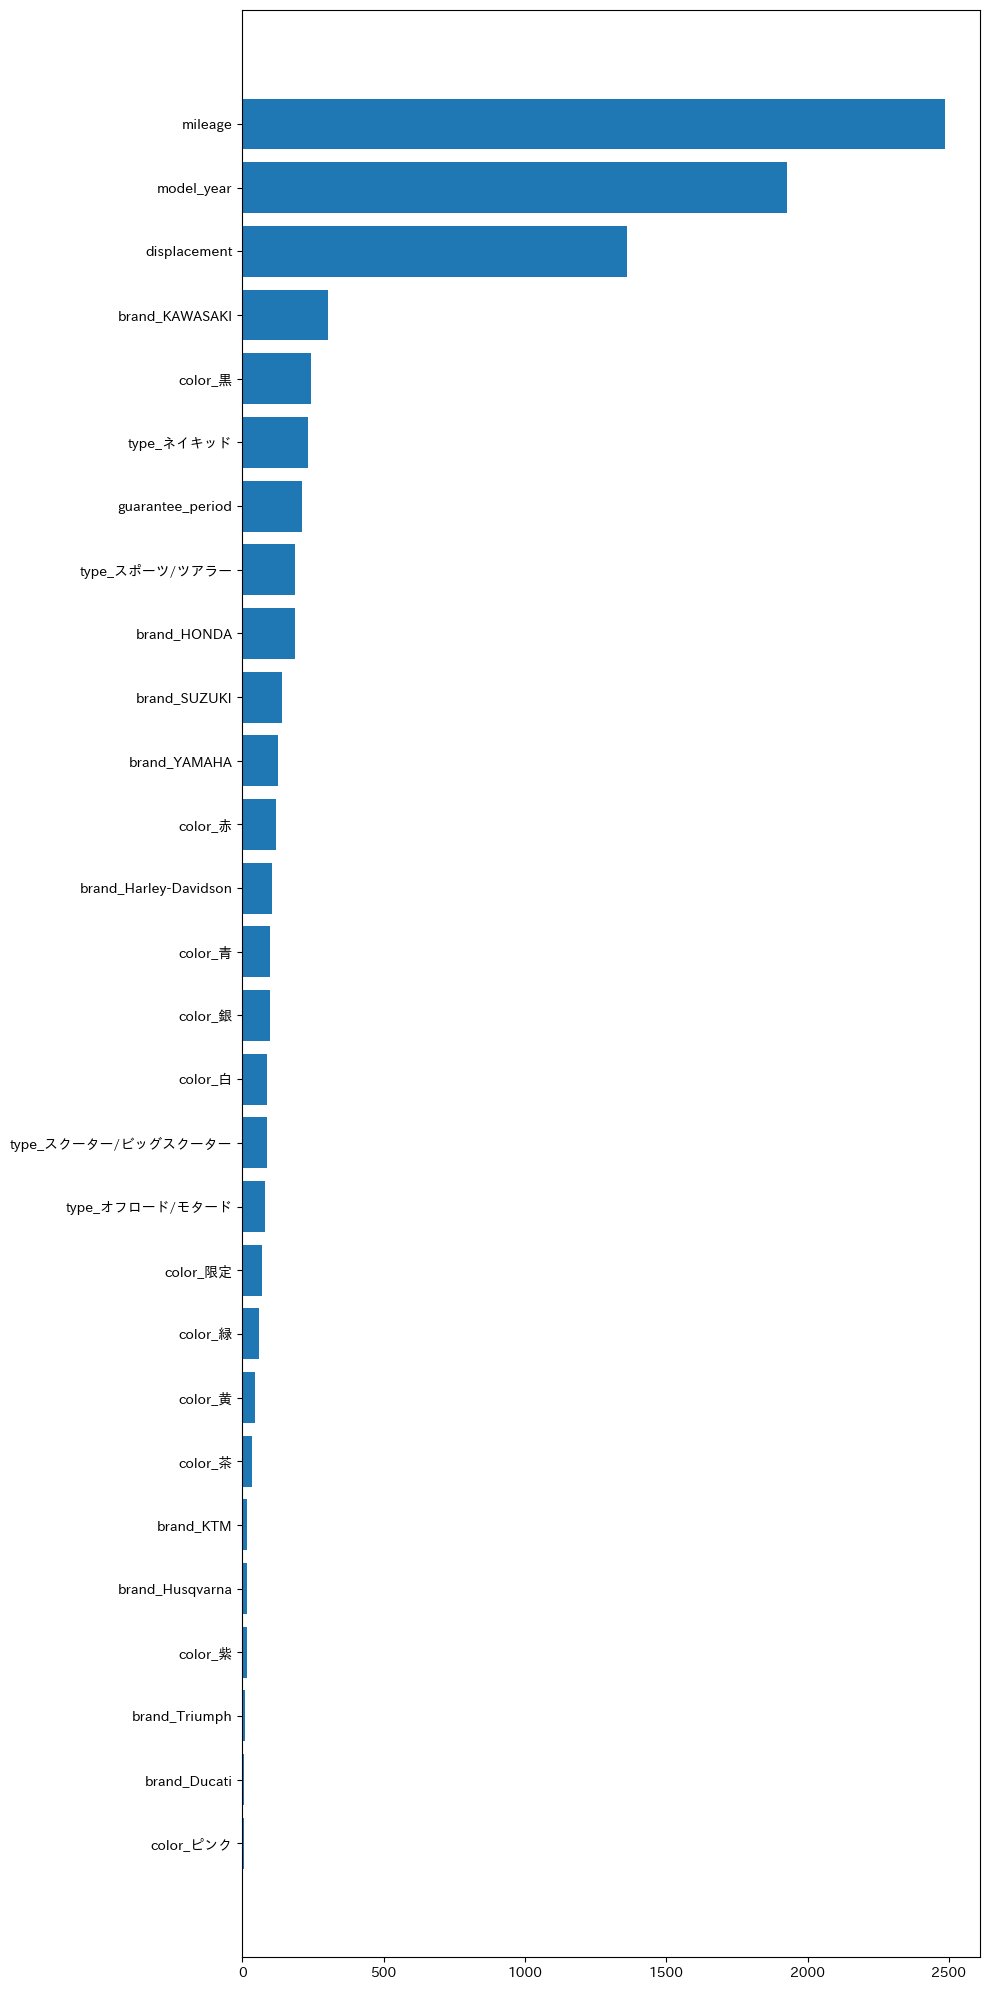

In [24]:
#feature_importanceも確認してみる
plt.subplots(figsize=(10,20))
featuer_name = train_data.drop(columns=['id','cost','model_number','name','store_id']).columns
importances = model_2.feature_importance()
indices = np.argsort(importances)
plt.barh(np.asarray(featuer_name)[indices],importances[indices])
plt.tight_layout()
plt.show()


In [25]:
test_data = pd.read_csv('../data/機械学習用/test_data.csv',index_col=0)
test_data=test_data.merge(model_data,on='model_number',how='left')
test_data.dropna(inplace=True)

In [26]:
test_data

,id,cost,model_number,model_year,color,mileage,guarantee_period,store_id,brand,name,type,displacement
0,2100006178999,388000,2BK-DN11A,2021.0,青,5034.0,5,63,SUZUKI,GSX250R,スポーツ/ツアラー,250.0
1,2100005344975,1480000,2BL-ZR900C,2020.0,緑,8354.0,5,50,KAWASAKI,Z900RS,ネイキッド,950.0
2,2100006036176,148000,JBH-SA52J,2016.0,青,11896.0,3,50,YAMAHA,VOX,スクーター/ビッグスクーター,50.0
3,2100005759090,1428000,JD5,2010.0,黒,15498.0,3,27,Harley-Davidson,FLSTN1580,アメリカン/クルーザー,1580.0
4,2100006282986,1100000,2BL-NC42,2020.0,白,12067.0,3,65,HONDA,CB400 SUPER FOUR HYPER VTEC Revo,ネイキッド,400.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1117,2100005863018,498000,2BL-RH13J,2018.0,青,3371.0,5,46,YAMAHA,YZFR3,ネイキッド,320.0
1118,2100005567510,588000,2BL-NC59,2021.0,黒,21834.0,1,13,HONDA,GB350,ネイキッド,350.0
1119,2100006115840,2898000,2BL-FLC,2018.0,黒,8920.0,5,36,Harley-Davidson,FLTRX1750Road Glide Special,アメリカン/クルーザー,1750.0
1120,2100005856706,1368000,LC3,2011.0,銀,14216.0,3,1,Harley-Davidson,XL1200X,アメリカン/クルーザー,1200.0


In [27]:
#ダミーエンコーディング
test_data = pd.get_dummies(test_data,drop_first=True,columns=encoding_target)


In [28]:
X_test=test_data.iloc[:,2:].drop(columns=['name','model_number','store_id']).values
y_test = test_data['cost'].values

In [29]:
train_ds = opt_lgb.Dataset(X,y)
test_ds = opt_lgb.Dataset(X_test,y_test)


model_2 = lgb.train(best_params,
                    train_set= train_ds,
                    valid_sets= test_ds,
                    num_boost_round=10000,
                    callbacks=[lgb.early_stopping(stopping_rounds=100,verbose=100)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 4481, number of used features: 28
[LightGBM] [Info] Start training from score 742989.453247
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[145]	valid_0's mape: 0.159066


In [30]:
predict_train = model_2.predict(X)
predict_test = model_2.predict(X_test)

In [31]:
print('訓練データ決定係数',r2_score(y_true=y,y_pred=predict_train))
print('テストデータ決定係数',r2_score(y_true=y_test,y_pred=predict_test))
print('訓練データMAPE',mean_absolute_percentage_error(y_true=y,y_pred=predict_train))
print('テストデータMAPE',mean_absolute_percentage_error(y_true=y_test,y_pred=predict_test))

訓練データ決定係数 0.9886350866681443
テストデータ決定係数 0.7724904063586567
訓練データMAPE 0.0775194534610013
テストデータMAPE 0.1590659126331084
